# Estimating the distribution of event timescales

In this example, we will construct a model to predict the distribution of microlensing event timescales. The aim of this exercise is to show how these calculations are made, rather than building a realistic model.

The model is indeed based on very simple assumptions. In particular:
* the distribution of lens masses is modeled either using a power-law or an exponential distribution;
* the distribution of source distances is gaussian and strongly peaked at $D_S=8$ kpc;
* the distribution of lens distances is uniform between $D_L=0$ and $D_L=8$ kpc;
* the distribution of the lens-source relative velocities is gaussian and it peaks at $v=200$ km/s

We start by importing the usual packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate as interpolate
import numpy.random as ra
from scipy.interpolate import interp1d
import scipy.stats as stats
%matplotlib inline

The problem to be addressed here is that of sampling a Probability Distribution Function (PDF). To do that we employ a method called ***inverse transform sampling*** which involves the following steps:
* we begin from the known PDF we want to sample and we compute its cumulative function
* we invert the cumulative function
* we generate random numbers in the range [0,1]
* we read-off the corresponding values returned by the inverted cumulative function.


The procedure is outlined in this example (see [this link](http://people.duke.edu/~ccc14/sta-663-2016/15A_RandomNumbers.html)), which uses and exponential distribution.

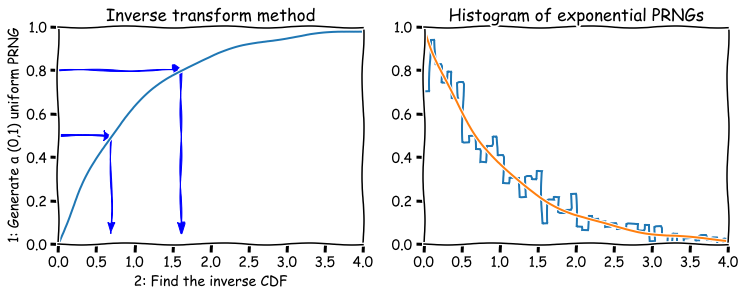

In [13]:
def expon_pdf(x, lmabd=1):
    """PDF of exponential distribution."""
    return lmabd*np.exp(-lmabd*x)

def expon_cdf(x, lambd=1):
    """CDF of exponetial distribution."""
    return 1 - np.exp(-lambd*x)

def expon_icdf(p, lambd=1):
    """Inverse CDF of exponential distribution - i.e. quantile function."""
    return -np.log(1-p)/lambd

import scipy.stats as stats

dist = stats.expon()
x = np.linspace(0,4,100)
y = np.linspace(0,1,100)

with plt.xkcd():
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    plt.plot(x, expon_cdf(x))
    plt.axis([0, 4, 0, 1])
    for q in [0.5, 0.8]:
        plt.arrow(0, q, expon_icdf(q)-0.1, 0, head_width=0.05, head_length=0.1, fc='b', ec='b')
        plt.arrow(expon_icdf(q), q, 0, -q+0.1, head_width=0.1, head_length=0.05, fc='b', ec='b')
    plt.ylabel('1: Generate a (0,1) uniform PRNG')
    plt.xlabel('2: Find the inverse CDF')
    plt.title('Inverse transform method');

    plt.subplot(122)
    u = np.random.random(1000)
    v = expon_icdf(u)
    plt.hist(v, histtype='step', bins=100, density=True, linewidth=2)
    plt.plot(x, expon_pdf(x), linewidth=2)
    plt.axis([0,4
              ,0,1])
    plt.title('Histogram of exponential PRNGs');

We use the exponential PDF above to generate the masses of 1000 lenses:

In [3]:
mass=v  # masses of 1000 lenses (in the range [0,4])

The same methodology can be empolyed with any kind of PDF. In many cases (for the most common PDFs) we won't need to implement the whole procedure because ```numpy``` does the job for us. For example, we may use an exponential PDF: 

/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in power
  # Remove the CWD from sys.path while we load stuff.


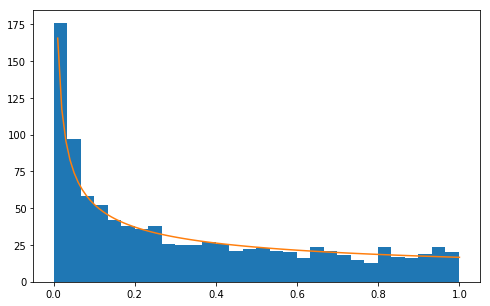

In [4]:
a = 0.5 # shape
samples = 1000
# use the 'power' PDF in numpy.random
s = np.random.power(a, samples) 

fig,ax=plt.subplots(1,1,figsize=(8,5))
count, bins, ignored = ax.hist(s, bins=30)
# compare with the input PDF
x = np.linspace(0, 1, 100)
y = a*x**(a-1.)
normed_y = samples*np.diff(bins)[0]*y
ax.plot(x, normed_y)
# rescale the masses to be in the range [0,4]
mass2=s*4.0

Having sampled the distribution of the lens masses (using two different models), we now need generate the other relevant quantities ($D_L$, $D_S$, $v$). We make the assumption that these quantities are not correlated. In other words, we assume that all quantities are independent, which implies that the distribution of one quantity is not conditioned by the disstribution of the others.

For the source distances, we assume that the sources are located e.g. in the bulge of our galaxy, which is $\sim 8$ kpc away from us. Thus, we choose to model the PDF os $D_S$ as a gaussian with mean $\mu=8$ kpc and a standard deviation $\sigma=0.3$ kpc.

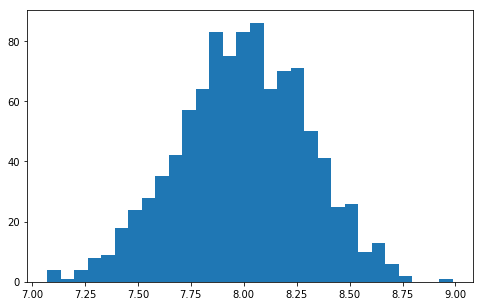

In [5]:
# source distances
mu, sigma = 8.0, 0.3
s = np.random.normal(mu, sigma, samples)

fig,ax=plt.subplots(1,1,figsize=(8,5))
count, bins, ignored = ax.hist(s, bins=30)

ds=s

Now we generate the lens distances. For $D_L$ we use a uniform PDF in the range [0,min($D_S$)]. In principle, we should account for events that involve sources in the far bulge but we assume they can be neglected in this simple example.

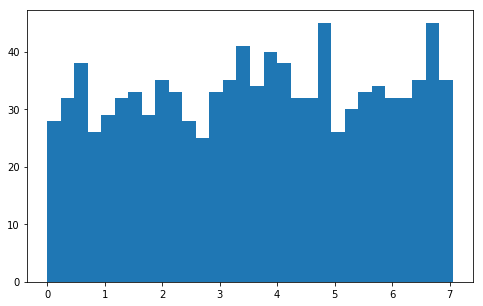

In [6]:
# lens distances
dmin, dmax = 0.0, np.min(ds)
s = np.random.uniform(dmin, dmax, samples)

fig,ax=plt.subplots(1,1,figsize=(8,5))
count, bins, ignored = ax.hist(s, bins=30)

dl=s

Finally, we generate the relative velocities. We assume that these are normally distributed, with $\mu=200$ km/s and $\sigma=10$ km/s

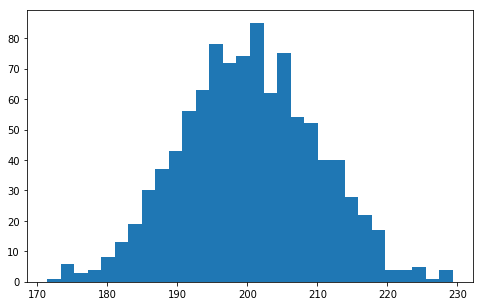

In [8]:
# lens velocities
mu, sigma = 200.0, 10.0
s = np.random.normal(mu, sigma, samples)

fig,ax=plt.subplots(1,1,figsize=(8,5))
count, bins, ignored = ax.hist(s, bins=30)

vel=s

We now have everything which is needed to compute the $t_E$ for each event. Then, we show the distribution of the event timescales in the two cases considered for the lens mass function (exponential vs power-law).

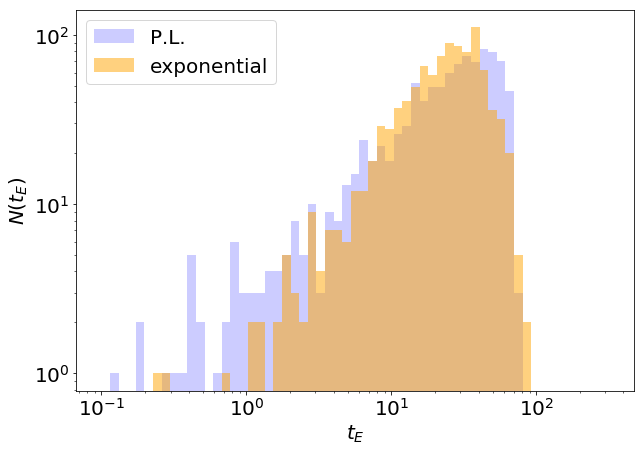

In [9]:
from astropy import constants as const
from astropy import units as u
# the Einstein radius 
def theta_e_func(M,DL,DS):
    mass=M*const.M_sun
    G=const.G
    c=c=const.c
    aconv=180.0*3600.0/np.pi*u.arcsecond    
    theta_E=np.sqrt(4.0*(G*mass/c/c).to('kpc')*(DS-DL)/DL/DS/u.kpc)*aconv
    return(theta_E)

# the Einstein radius crossing time
def EinsteinCrossTime(M,DL,DS,v):
    theta_e=theta_e_func(M,DL,DS)
    return(((theta_e.to('radian').value*DL*u.kpc).to('km')
            /v/u.km*u.s).to('day'))

fig,ax=plt.subplots(1,1,figsize=(10,7))
tE=EinsteinCrossTime(mass,dl,ds,vel)

tE2=EinsteinCrossTime(mass2,dl,ds,vel)

count, bins, ignored = ax.hist(tE2,alpha=0.2,
                               bins=np.logspace(-1,2.5,60),
                               color='blue',label='P.L.')
count, bins, ignored = ax.hist(tE,alpha=0.5,
                               bins=np.logspace(-1,2.5,60),
                               color='orange',label='exponential')
ax.legend(fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$t_E$',fontsize=20)
ax.set_ylabel(r'$N(t_E)$',fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)

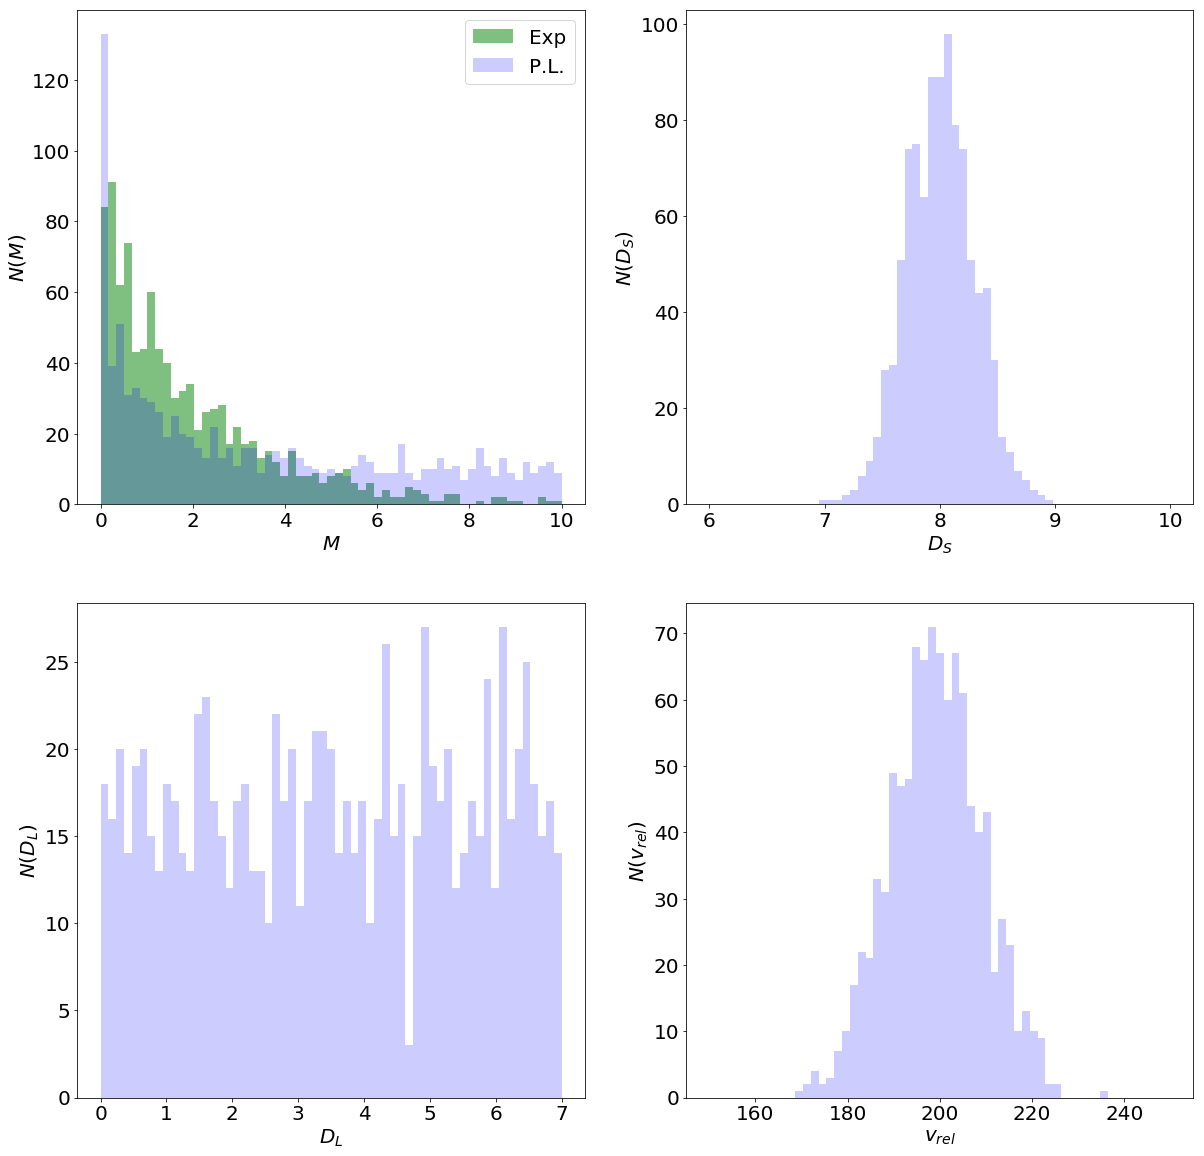

In [49]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
samples=1000
lambd=0.5
# draw samples from  an exponential PDF with rate parameter lambd:
mass_exp=np.random.exponential(size=samples,scale=1.0/lambd)
# draw samples from  a gaussian PDF with mean mu and 
# standard deviation sigma:
mu=1.0
sigma=0.2
x_norm=np.random.normal(loc=mu,scale=sigma,size=samples)
# draw samples from a uniform distribution
a=0
b=2
x_unif=np.random.uniform(low=a,high=b,size=samples)
# draw samples from a power-law distribution
a = 0.5 # shape
# use the 'power' PDF in numpy.random
mass_pow = np.random.power(a, samples) 

fig,ax=plt.subplots(2,2,figsize=(20,20))
count, bins, ignored = ax[0,0].hist(x_exp,alpha=0.5,
                               bins=np.linspace(0,10,60),
                               color='green',label='Exp')
count, bins, ignored = ax[0,0].hist(mass_pow*10,alpha=0.2,
                               bins=np.linspace(0,10,60),
                               color='blue',label='P.L.')

ax[0,0].legend(fontsize=20)
#ax.set_xscale('log')
#ax.set_yscale('log')

ax[0,0].set_xlabel(r'$M$',fontsize=20)
ax[0,0].set_ylabel(r'$N(M)$',fontsize=20)
ax[0,0].xaxis.set_tick_params(labelsize=20)
ax[0,0].yaxis.set_tick_params(labelsize=20)

mu, sigma = 8.0, 0.3
ds=np.random.normal(loc=mu,scale=sigma,size=samples)
count, bins, ignored = ax[0,1].hist(ds,alpha=0.2,
                               bins=np.linspace(6,10,60),
                               color='blue')
ax[0,1].set_xlabel(r'$D_S$',fontsize=20)
ax[0,1].set_ylabel(r'$N(D_S)$',fontsize=20)
ax[0,1].xaxis.set_tick_params(labelsize=20)
ax[0,1].yaxis.set_tick_params(labelsize=20)

# lens distances
dmin, dmax = 0.0, np.min(ds)
dl = np.random.uniform(dmin, dmax, samples)
count, bins, ignored = ax[1,0].hist(dl,alpha=0.2,
                               bins=np.linspace(0,7,60),
                               color='blue')
ax[1,0].set_xlabel(r'$D_L$',fontsize=20)
ax[1,0].set_ylabel(r'$N(D_L)$',fontsize=20)
ax[1,0].xaxis.set_tick_params(labelsize=20)
ax[1,0].yaxis.set_tick_params(labelsize=20)

mu, sigma = 200.0, 10.0
vel=np.random.normal(loc=mu,scale=sigma,size=samples)
count, bins, ignored = ax[1,1].hist(vel,alpha=0.2,
                               bins=np.linspace(150,250,60),
                               color='blue')
ax[1,1].set_xlabel(r'$v_{rel}$',fontsize=20)
ax[1,1].set_ylabel(r'$N(v_{rel})$',fontsize=20)
ax[1,1].xaxis.set_tick_params(labelsize=20)
ax[1,1].yaxis.set_tick_params(labelsize=20)
fig.savefig('example_te_distr.png')

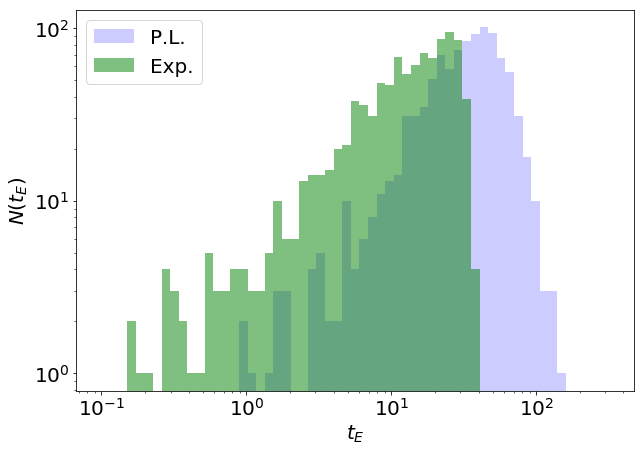

In [47]:
from astropy import constants as const
from astropy import units as u
# the Einstein radius 
def theta_e_func(M,DL,DS):
    mass=M*const.M_sun
    G=const.G
    c=c=const.c
    aconv=180.0*3600.0/np.pi*u.arcsecond    
    theta_E=np.sqrt(4.0*(G*mass/c/c).to('kpc')*(DS-DL)/DL/DS/u.kpc)*aconv
    return(theta_E)

# the Einstein radius crossing time
def EinsteinCrossTime(M,DL,DS,v):
    theta_e=theta_e_func(M,DL,DS)
    return(((theta_e.to('radian').value*DL*u.kpc).to('km')
            /v/u.km*u.s).to('day'))

fig,ax=plt.subplots(1,1,figsize=(10,7))
tE=EinsteinCrossTime(mass_pow,dl,ds,vel)

tE2=EinsteinCrossTime(mass_exp,dl,ds,vel)

count, bins, ignored = ax.hist(tE2,alpha=0.2,
                               bins=np.logspace(-1,2.5,60),
                               color='blue',label='P.L.')
count, bins, ignored = ax.hist(tE,alpha=0.5,
                               bins=np.logspace(-1,2.5,60),
                               color='green',label='Exp.')
ax.legend(fontsize=20)
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(r'$t_E$',fontsize=20)
ax.set_ylabel(r'$N(t_E)$',fontsize=20)
ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)
fig.savefig('ex_te.png')